# Simulating Thermal Behavior of Brake Discs During Braking Maneuvers

## Initial Setup and Parameters

In [89]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

# Constants and Input Data
m = 290                     # Car mass in kg
I = 0.3546                  # Moment of inertia of the rotating parts on the wheel [kg/m^2]
V_i = 70 / 3.6              # Initial vehicle speed [m/s]
V_f = 45 / 3.6              # Final vehicle speed [m/s]
V_mean = (V_f + V_i) / 2
R_wheel = 0.235  # Wheel radius [m]
omega_i = V_i / R_wheel  # Initial wheel angular speed [rad/s]
omega_f = V_f / R_wheel  # Final wheel angular speed [rad/s]
Decel_avg = 0.5 * 9.81  # Average deceleration [m/s^2]
Brake_bias = 0.5  # Portion of the total braking load applied to the axle
t_stop = (V_i - V_f) / Decel_avg  # Duration of the braking maneuver [s]
d_stop = (V_i**2 - V_f**2) / (2 * Decel_avg)  # Distance covered during braking [m]
t_cool = 5  # Cooling time between braking maneuvers [s]
n_materials = 6  # Number of materials to compare
n = 100  # Number of braking maneuvers to simulate
Cx = 1.12  # Aerodynamic drag coefficient
S_car = 1  # Front surface area of the car [m^2]


## Disk Data

In [90]:
# ----------------- FRONT DISC -----------------
r_disc = 218 / 2 / 1000  # Disc outer radius [m]
h_disc = 30 / 1000       # Disc height [m]
t_disc = 3 / 1000        # Disc thickness [m]
d_holes = 3 / 1000       # Holes diameter [m]
N_holes = 200            # Number of holes

# Calculate areas
A_edge = 2 * np.pi * r_disc * t_disc  # Area of edge [m^2]
A_fix = 306.53 / 1e6                 # Area of one of the fixing legs of the rotor [m^2]
A_side = np.pi * (r_disc**2 - (r_disc - h_disc)**2) - N_holes * (np.pi * (d_holes / 2)**2) + A_fix * 6  # Side area [m^2]
A_holes = N_holes * np.pi * d_holes * t_disc  # Area of the holes walls [m^2]
V_disc = A_side * t_disc                      # Volume of the brake rotor [m^3]
A_total = A_edge + 2 * A_side + A_holes       # Total surface area of the disc [m^2]

# Area ratios
A_ratio_side = A_side / A_total
A_ratio_edge = A_edge / A_total

# ----------------- REAR DISC (commented in MATLAB, provided for completeness) -----------------
r_disc_rear = 190 / 2 / 1000  # Rear disc outer radius [m]
h_disc_rear = 24 / 1000       # Rear disc height [m]
t_disc_rear = 4 / 1000        # Rear disc thickness [m]
d_holes_rear = 8 / 1000       # Rear holes diameter [m]
N_holes_rear = 36             # Number of holes

# Calculate rear disc areas
A_edge_rear = 2 * np.pi * r_disc_rear * t_disc_rear  # Rear area of edge [m^2]
A_fix_rear = 347.2 / 1e6                            # Rear area of one of the fixing legs [m^2]
A_side_rear = np.pi * (r_disc_rear**2 - (r_disc_rear - h_disc_rear)**2) - \
              N_holes_rear * (np.pi * (d_holes_rear / 2)**2) + A_fix_rear * 6  # Rear side area [m^2]
A_holes_rear = N_holes_rear * np.pi * d_holes_rear * t_disc_rear  # Rear area of holes walls [m^2]
V_disc_rear = A_side_rear * t_disc_rear                             # Rear volume of the brake rotor [m^3]

# ----------------- PAD PROPERTIES -----------------
h_pad = 30 / 1000    # Pad height [m]
w_pad = 0.04975      # Pad width [m]
S_p = h_pad * w_pad  # Pad friction area [m^2]
t_pad = 4 / 1000     # Pad compound thickness [m]
t_plate = 3.5 / 1000 # Thickness of the backing plate [m]
S_d = np.pi * (r_disc**2 - (r_disc - h_pad)**2) - N_holes * (np.pi * (d_holes / 2)**2)  # Disc friction area [m^2]

k_pad = 12           # 1.31 # Thermal Conductivity of the pad [W/mK]
Cp_pad= 900          # 1230 # Specific Heat of the pad material [J/kgK]
rho_pad = 2500       # 2400  # Density [kg/m3]
k_plate= 15          # Thermal Conductivity of the backing plate[W/mK]
              #Assumed to be a low conductivity stainless steel alloy
              #This is a worst case, since it could be titanium.


## Air Props

In [91]:
# Define the air properties based on the provided data
air_props_data = np.array([
    [-150, 2.866, 983, 0.01171, 4.158e-06, 8.636e-06, 3.013e-06, 0.7246],
    [-100, 2.038, 966, 0.01582, 8.036e-06, 1.189e-06, 5.837e-06, 0.7263],
    [-50, 1.582, 999, 0.01979, 1.252e-05, 1.474e-05, 9.319e-06, 0.7440],
    [-40, 1.514, 1002, 0.02057, 1.356e-05, 1.527e-05, 1.008e-05, 0.7436],
    [-30, 1.451, 1004, 0.02134, 1.465e-05, 1.579e-05, 1.087e-05, 0.7425],
    [-20, 1.394, 1005, 0.02211, 1.578e-05, 1.630e-05, 1.169e-05, 0.7408],
    [-10, 1.341, 1006, 0.02288, 1.696e-05, 1.680e-05, 1.252e-05, 0.7387],
    [0, 1.292, 1006, 0.02364, 1.818e-05, 1.729e-05, 1.338e-05, 0.7362],
    [10, 1.246, 1006, 0.02439, 1.944e-05, 1.778e-05, 1.426e-05, 0.7336],
    [20, 1.204, 1007, 0.02514, 2.074e-05, 1.825e-05, 1.516e-05, 0.7309],
    [30, 1.164, 1007, 0.02588, 2.208e-05, 1.872e-05, 1.608e-05, 0.7282],
    [40, 1.127, 1007, 0.02662, 2.346e-05, 1.918e-05, 1.702e-05, 0.7255],
    [50, 1.092, 1007, 0.02735, 2.487e-05, 1.963e-05, 1.798e-05, 0.7228],
    [60, 1.059, 1007, 0.02808, 2.632e-05, 2.008e-05, 1.896e-05, 0.7202],
    [70, 1.028, 1007, 0.02881, 2.780e-05, 2.052e-05, 1.995e-05, 0.7177],
    [80, 0.9994, 1008, 0.02953, 2.931e-05, 2.096e-05, 2.097e-05, 0.7154],
    [90, 0.9718, 1008, 0.03024, 3.086e-05, 2.139e-05, 2.201e-05, 0.7132],
    [100, 0.9458, 1009, 0.03095, 3.243e-05, 2.181e-05, 2.306e-05, 0.7111],
    [120, 0.8977, 1011, 0.03235, 3.565e-05, 2.264e-05, 2.522e-05, 0.7073],
    [140, 0.8542, 1013, 0.03374, 3.898e-05, 2.345e-05, 2.745e-05, 0.7041],
    [160, 0.8148, 1016, 0.03511, 4.241e-05, 2.420e-05, 2.975e-05, 0.7014],
    [180, 0.7788, 1019, 0.03646, 4.593e-05, 2.504e-05, 3.212e-05, 0.6992],
    [200, 0.7459, 1023, 0.03779, 4.954e-05, 2.577e-05, 3.455e-05, 0.6974],
    [250, 0.6746, 1033, 0.04104, 5.890e-05, 2.760e-05, 4.091e-05, 0.6946],
    [300, 0.6158, 1044, 0.04418, 6.871e-05, 2.934e-05, 4.765e-05, 0.6935],
    [350, 0.5664, 1056, 0.04721, 7.892e-05, 3.101e-05, 5.475e-05, 0.6937],
    [400, 0.5243, 1069, 0.05015, 8.951e-05, 3.261e-05, 6.219e-05, 0.6948],
    [450, 0.488, 1081, 0.05298, 1.004e-04, 3.415e-05, 6.997e-05, 0.6965],
    [500, 0.4565, 1093, 0.05572, 1.117e-04, 3.563e-05, 7.806e-05, 0.6986],
    [600, 0.4042, 1115, 0.06093, 1.352e-04, 3.846e-05, 9.515e-05, 0.7037],
    [700, 0.3627, 1135, 0.06581, 1.598e-04, 4.111e-05, 1.133e-04, 0.7092],
    [800, 0.3289, 1153, 0.07037, 1.855e-04, 4.362e-05, 1.326e-04, 0.7149],
    [900, 0.3008, 1169, 0.07465, 2.122e-04, 4.600e-05, 1.529e-04, 0.7206],
    [1000, 0.2772, 1184, 0.07868, 2.398e-04, 4.826e-05, 1.741e-04, 0.7260],
    [1500, 0.199, 1234, 0.09599, 3.908e-04, 5.817e-05, 2.922e-04, 0.7478],
    [2000, 0.1553, 1264, 0.11113, 5.664e-04, 6.630e-05, 4.270e-04, 0.7539]
])

# Define the columns for air properties
Air_props = {
    'Temp': air_props_data[:, 0],
    'Density': air_props_data[:, 1],
    'Spec_Heat': air_props_data[:, 2],
    'Conductivity': air_props_data[:, 3],
    'Dyn_Visc': air_props_data[:, 4],
    'Kin_Visc': air_props_data[:, 5],
    'Prandtl': air_props_data[:, 6]
}

Air_props.keys(), Air_props['Temp'][:5], Air_props['Density'][:5]


(dict_keys(['Temp', 'Density', 'Spec_Heat', 'Conductivity', 'Dyn_Visc', 'Kin_Visc', 'Prandtl']),
 array([-150., -100.,  -50.,  -40.,  -30.]),
 array([2.866, 2.038, 1.582, 1.514, 1.451]))

### Average power dissipated during the single braking maneuver

$E_k =\frac{1}{2}{\mathrm{Bias}}_{\mathrm{front}\;} \left(\frac{1}{2}m\left(V_i^2 -V_{f\;}^2 \right)-\frac{1}{2}\rho {\;}_{\mathrm{air}\;} C_{x\;} {\mathrm{SV}}_{\mathrm{avg}}^2 d_{\mathrm{stop}} \right)+\frac{1}{2}I\left(\omega {\;}_i^2 -\omega {\;}_f^2 \right)$

Kinetic linear and rotational energies minus approximately the average energy dissipated by the aerodynamic drag.

In [92]:

Ef = 0.5 * Brake_bias * ((m / 2) * (V_i**2 - V_f**2) - 0.5 * 1.16 * Cx * S_car * ((V_i + V_f) / 2)**2 * d_stop) + \
     (I / 2) * (omega_i**2 - omega_f**2)
Ef

7816.903961196209

In [93]:
P_avgF = Ef / t_stop; #Average power dissipated during the braking maneuver [W]
P_avgF

5521.235605872108

## Mat Properties

In [94]:
# Function to calculate material properties based on temperature and material type
def material_properties(T_disc, mat):
    """
    Returns the material properties for a given disc temperature and material type.
    
    Parameters:
    T_disc (float): Temperature of the disc in Kelvin
    mat (int): Material type (1-6)

    Returns:
    rho_metal (float): Density [kg/m^3]
    k_metal (float): Thermal Conductivity [W/mK]
    Cp_metal (float): Specific Heat [J/kgK]
    k_pad (float): Thermal Conductivity of the pad [W/mK]
    Cp_pad (float): Specific Heat of the pad [J/kgK]
    rho_pad (float): Density of the pad [kg/m^3]
    k_plate (float): Thermal Conductivity of the backing plate [W/mK]
    """

    # Convert temperature to Celsius for the calculation
    T = T_disc - 273.15

    # Material properties based on the given material type
    if mat == 1:
        rho_metal = 7740  # Density [kg/m^3]
        if T < 100:
            k_metal = 24.9  # Thermal Conductivity [W/mK]
            Cp_metal = 460  # Specific Heat [J/kgK]
        else:
            k_metal = 0.0095 * T + 23.95  # Thermal Conductivity [W/mK]
            Cp_metal = 0.1 * T + 450  # Specific Heat [J/kgK]
    
    elif mat == 2:
        rho_metal = 7800  # Density [kg/m^3]
        k_metal = (0.00008980370684893290 * T + 0.20061671922950300000) * 100  # Thermal Conductivity [W/mK]
        Cp_metal = (0.00004814992250246590 * T + 0.11139284204593500000) * 4184  # Specific Heat [J/kgK]

    elif mat == 3:
        rho_metal = 2760  # Density [kg/m^3]
        k_metal = 180  # Thermal Conductivity [W/mK]
        Cp_metal = 950  # Specific Heat [J/kgK]

    elif mat == 4:
        rho_metal = 4420  # Density [kg/m^3]
        k_metal = 6.7  # Thermal Conductivity [W/mK]
        Cp_metal = 526  # Specific Heat [J/kgK]

    elif mat == 5:
        rho_metal = 7850  # Density [kg/m^3]
        k_metal = 49.8  # Thermal Conductivity [W/mK]
        Cp_metal = 502  # Specific Heat [J/kgK]

    elif mat == 6:
        rho_metal = 7150  # Density [kg/m^3]
        k_metal = 53.3  # Thermal Conductivity [W/mK]
        Cp_metal = 490  # Specific Heat [J/kgK]

    else:
        raise ValueError("Invalid material type. Must be between 1 and 6.")

    # Pad properties (constant)
    k_pad = 12  # Thermal Conductivity of the pad [W/mK]
    Cp_pad = 900  # Specific Heat of the pad material [J/kgK]
    rho_pad = 2500  # Density of the pad [kg/m^3]

    # Backing plate properties
    k_plate = 15  # Thermal Conductivity of the backing plate [W/mK]

    return rho_metal, k_metal, Cp_metal, k_pad, Cp_pad, rho_pad, k_plate


## Simulation Setup

In [95]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Number of time steps (assuming 'n' is defined)
n_time_steps = 2 * n

# Initialize arrays
T_disc = np.zeros(n_time_steps)
T_film = np.zeros(n_time_steps)
h_conv = np.zeros(n_time_steps)
rho_air_f = np.zeros(n_time_steps)
mu_air_f = np.zeros(n_time_steps)
Cp_air_f = np.zeros(n_time_steps)
k_air_f = np.zeros(n_time_steps)
Re_f = np.zeros(n_time_steps)
Pr_f = np.zeros(n_time_steps)
BixFo = np.zeros(n_time_steps)

# Initialize results matrix
T_disc_mat = np.zeros((n_materials, n_time_steps))

# Define interpolation functions for air properties
f_rho_air = interp1d(Air_props['Temp'], Air_props['Density'], kind='linear', fill_value="extrapolate")
f_Cp_air = interp1d(Air_props['Temp'], Air_props['Spec_Heat'], kind='linear', fill_value="extrapolate")
f_k_air = interp1d(Air_props['Temp'], Air_props['Conductivity'], kind='linear', fill_value="extrapolate")
f_mu_air = interp1d(Air_props['Temp'], Air_props['Dyn_Visc'], kind='linear', fill_value="extrapolate")

# Air properties interpolation functions (assuming Air_props data is loaded)
def get_air_properties(T):
    T_C = T - 273.15  # Convert to Celsius for interpolation
    rho_air = f_rho_air(T_C)
    mu_air = f_mu_air(T_C)
    Cp_air = f_Cp_air(T_C)
    k_air = f_k_air(T_C)
    return rho_air, mu_air, Cp_air, k_air



# Simulation

In [96]:
for mat in range(n_materials):
    # Initialize material-specific properties
    # Load initial material properties at T_disc[0]
    T_disc[0] = 60 + 273.15  # Initial disc temperature [K]
    T_air = 22 + 273.15      # Air temperature [K]
    rho_metal, k_metal, Cp_metal, k_pad, Cp_pad, rho_pad, k_plate = material_properties(T_disc[0], mat + 1)

    # Initialize variables
    Dt_cool = 0
    DT_f = 0

    for i in range(n_time_steps):
        if i > 0 and (i % 2) == 1:
            # **Cooling Phase**
            T_disc[i] = T_disc[i - 1] - Dt_cool
        elif (i % 2) == 0:
            # **Braking Phase**
            if i == 0:
                # Initial braking phase
                T_disc[i] = 60 + 273.15
            else:
                # Calculate BixFo
                BixFo = h_conv[i - 2] * A_total * t_cool / (rho_metal * V_disc * Cp_metal)
                T_disc[i] = T_air + (1 - np.exp(-0.5 * (i + 1) * BixFo)) * DT_f / (1 - np.exp(-BixFo))

            # Update Air Temperature [K]
            T_air = 22 + 273.15

            # Film Temperature [K]
            T_film[i] = (T_air + T_disc[i]) / 2
            T_film_C = T_film[i] - 273.15  # Convert to Celsius for interpolation

            # Air properties at film temperature
            rho_air_f[i], mu_air_f[i], Cp_air_f[i], k_air_f[i] = get_air_properties(T_film[i])

            # Reynolds number
            Re_f[i] = (V_mean * 2 * r_disc * rho_air_f[i]) / mu_air_f[i]

            # Prandtl number
            Pr_f[i] = (mu_air_f[i] * Cp_air_f[i]) / k_air_f[i]

            # Heat transfer coefficient
            h_conv[i] = 0.04 * (k_air_f[i] / (2 * r_disc)) * Re_f[i] ** 0.8

            # Load material properties at current temperature
            rho_metal, k_metal, Cp_metal, k_pad, Cp_pad, rho_pad, k_plate = material_properties(T_disc[i], mat + 1)

            # Total surface area
            A_total = A_edge + 2 * A_side + A_holes

            # Biot number
            Bi = h_conv[i] * (V_disc / A_total) / k_metal
            if Bi > 0.1:
                raise ValueError("Biot number exceeds 0.1, invalid lumped capacitance assumption")

            # Thermal resistance calculations
            Rd = 1 / (A_total * h_conv[i])
            hp_conv = h_conv[i]
            Rp = 1 / hp_conv + t_pad / (k_pad * S_p) + t_plate / (k_plate * S_p)
            p = 1 / (1 + Rd / Rp)

            # Heat dissipated by convection and radiation
            H_convection = h_conv[i] * A_total * (T_disc[i] - T_air)
            H_radiation = 5.670367e-8 * A_total * 2 * (T_disc[i] - T_air) ** 4

            # Cooling factor
            f = (S_d - (2 * S_p)) / S_d  # Approximately 0.8

            # Compute cooling
            Dt_cool = (-H_convection - H_radiation) * t_cool / (rho_metal * V_disc * Cp_metal)

            # Compute temperature rise
            Dt_brake = P_avgF * t_stop * p / (rho_metal * V_disc * Cp_metal)
            DT_f = Dt_brake + Dt_cool * f

    # Save the results from the current material cycle
    T_disc_mat[mat, :] = T_disc

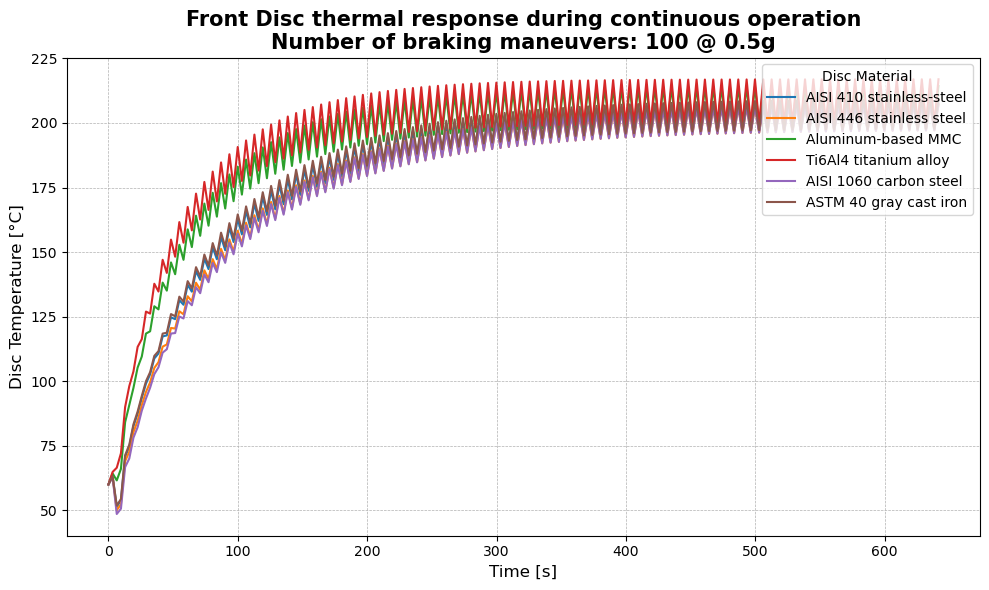

In [97]:
time = np.linspace(0, (t_stop + t_cool) * n, 2 * n)

# Plotting the results
plt.figure(figsize=(10, 6))

# Plot each material's temperature curve
for i, material in enumerate(['AISI 410 stainless-steel', 'AISI 446 stainless steel',
                              'Aluminum-based MMC', 'Ti6Al4 titanium alloy',
                              'AISI 1060 carbon steel', 'ASTM 40 gray cast iron']):
    plt.plot(time, T_disc_mat[i] - 273.15, label=material)

# Formatting
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel('Time [s]', fontsize=12)
plt.ylabel('Disc Temperature [°C]', fontsize=12)

# Title and subtitle
plottitle = 'Front Disc thermal response during continuous operation'
subtitle = f'Number of braking maneuvers: {n} @ {Decel_avg/9.81:.1f}g'
plt.title(f'{plottitle}\n{subtitle}', fontsize=15, fontweight='bold', color='black')

# Legend
plt.legend(title='Disc Material', loc='upper right', fontsize=10)

# Display the plot
plt.tight_layout()
plt.show()